(sec:data-visualization)=
# データ可視化と次元圧縮

機械学習において、データを扱う際には、データそのものがどのような性質を持っているかをよ事前に調べておくことが有効である。しかし、多くのデータは多次元のデータであるため、そのままデータがどのような分布になっているかを見ることは難しい。

そこで、データを2次元や3次元といった、人間にとって理解のしやすい次元に落として、データの分布の様子を見ることが必要になる。ここで用いるのが**次元圧縮**である。

次元圧縮には**線形**の次元圧縮と**非線形**の次元圧縮があり、線形の手法は、元のデータに何らかの行列を作用させて、低次元のベクトルを得る。それに対し、非線形の手法は元のデータを入力とする多変数関数を定義することで低次元のベクトルを得る。

次元圧縮を考える際、実際のデータは**高次元空間にランダムに存在している訳ではなく、ある程度の規則に従って散らばっている**ことを意識しておくことが大切である。このようなデータの散らばりは、ある程度、高次元空間上の曲面付近での散らばりと見なせることが多い。この曲面の構造をある種の**多様体**であると見なして、低次元空間への埋め込みを行う方法を、特に**多様体学習**と呼ぶ。

今回は、以下のスイスロールのデータとMNISTのデータを題材に次元圧縮と可視化の方法について見ていこう。

**スイスロールのデータ**

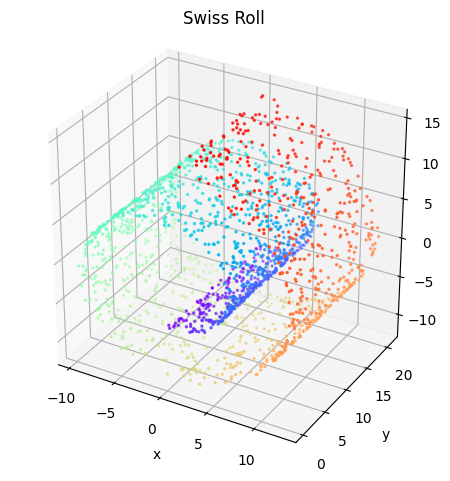

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from matplotlib import cm

# 実験に用いるサンプル数
n_samples = 2000

# データセットの取り出し
X_sr, y_sr = datasets.make_swiss_roll(n_samples=n_samples, noise=0.05)

# yの値を正規化して、色情報に変換しておく
y_sr = (y_sr - y_sr.min()) / (y_sr.max() - y_sr.min())
c = cm.rainbow(y_sr)

# 三次元プロットの表示
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_sr[:, 0], X_sr[:, 1], X_sr[:, 2], color=c, s=2)
ax.set_title("Swiss Roll")
ax.set_aspect("equalyz")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.tight_layout()
plt.show()

**MNISTのデータ**

In [2]:
# 以下のコードはデータのダウンロードを伴うため、少々時間がかかる
X, y = datasets.fetch_openml("mnist_784", return_X_y=True, data_home="./mnist", parser="auto")
X = np.array(X, dtype="uint8")
y = np.array(y, dtype="uint8")

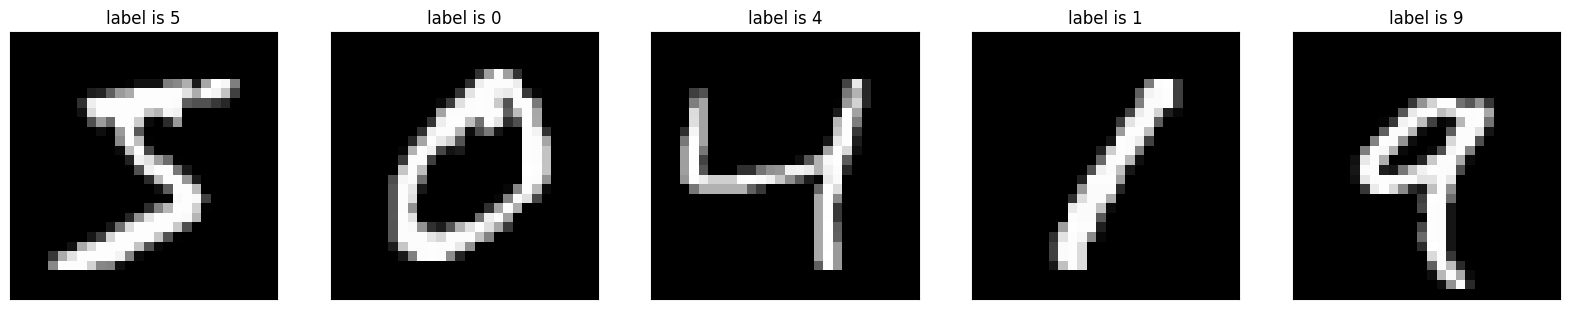

In [3]:
# 画像として見られるように配列の形を変更
ims = np.reshape(X[:5], (-1, 28, 28))

# 最初の5枚を確認してみる
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axs[i].imshow(ims[i], cmap="gray", interpolation=None)
    axs[i].set_title("label is {:d}".format(y[i]))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

例のごとく、実験にかかる時間を短縮するために、先頭数個のデータだけを実験に用いる。

In [4]:
from sklearn import model_selection

X, X_test = model_selection.train_test_split(X, train_size=60000, test_size=10000, shuffle=False)
y, y_test = model_selection.train_test_split(y, train_size=60000, test_size=10000, shuffle=False)

X, y = X[:n_samples], y[:n_samples]

## 主成分分析 (PCA)

**主成分分析** (PCA = Principal Component Analysis)は、データの散らばりが大きい方向に沿うように軸を取って次元圧縮を行う方法である。例えば、2次元空間に射影を行う場合、最も分散が大きな方向と次に分散が大きな方向を計算して、その2つの方向を基底ベクトルとして定義される低次元空間への射影を行う。

このようなデータの散らばりの性質を調べるには、データから定まる分散共分散行列を用いる。分散共分散行列はその固有ベクトルが散らばりの方向を、固有値が散らばりの大きさを表わす。

なお、本資料においては、与えられたデータ$\mathcal{X} = \{ \mathbf{x}_1, \ldots, \mathbf{x}_N \}$が標本ではなく、全てのデータを代表していると考えて、以下のように平均$\boldsymbol\mu$や分散共分散行列$\mathbf{C}$を計算する (情報科学の分野では、厳密性を排除して、このように計算することが多い)。

$$
\begin{aligned}
\boldsymbol\mu &= \frac{1}{N} \sum_{i=1}^N \mathbf{x}_i \\
\mathbf{C} &= \frac{1}{N} \sum_{i=1}^N (\bar{\mathbf{x}} - \mathbf{x}_i) (\bar{\mathbf{x}} - \mathbf{x}_i)^\top 
\end{aligned}
$$

NumPyを用いて、平均と分散共分散行列を計算すると、以下のようになる。

In [5]:
# 分散共分散行列の計算
mu_sr = np.mean(X_sr, axis=0, keepdims=True)
C_sr = np.dot((X_sr - mu_sr).T, X_sr - mu_sr) / n_samples

分散共分散行列は実対称行列であるので、固有値と固有ベクトルが必ず実数で求まる(実非対称行列の場合には、固有値や固有ベクトルが複素数になることがある)。固有値を求める場合は`np.linalg.eig`ではなく`np.linalg.eigh`を用いると、より効率が良い。

In [6]:
# 固有値分解
eigval, eigvec = np.linalg.eigh(C_sr)

# 固有値が大きい順にソートして、先頭の2つを取り出す
idx = np.flip(np.argsort(eigval))
eigval = eigval[idx[:2]]
eigvec = eigvec[:, idx[:2]].T

# 固有ベクトルの方向にデータを射影する
z_sr = X_sr @ eigvec.T

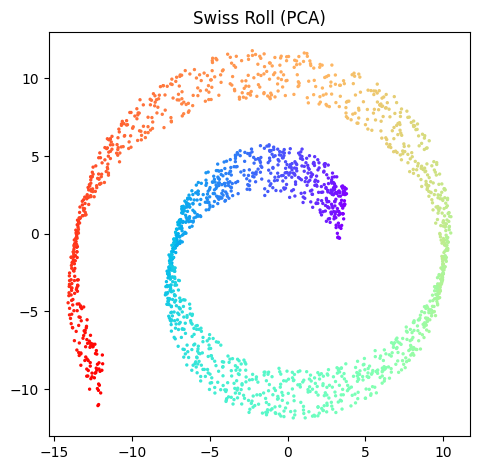

In [7]:
# データの可視化
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=2)
ax.set_title("Swiss Roll (PCA)")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

スイスロールのデータを二次元空間にPCAで射影してみると、予想通り、データの散らばりが大きなx軸方向とz軸方向を基底ベクトルとするxz平面上に射影されていることが分かる。

### 主成分分析の画像的な意味

次にMNISTのデータについて主成分分析をかけてみる。

In [8]:
mu = np.mean(X, axis=1, keepdims=True)
C = np.dot((X - mu).T, (X - mu)) / n_samples

# 固有値分解
eigval, eigvec = np.linalg.eigh(C)

# 固有値が大きい順にソートして、先頭の5つを取り出す
idx = np.flip(np.argsort(eigval))
eigval = eigval[idx[:5]]
eigvec = eigvec[:, idx[:5]].T

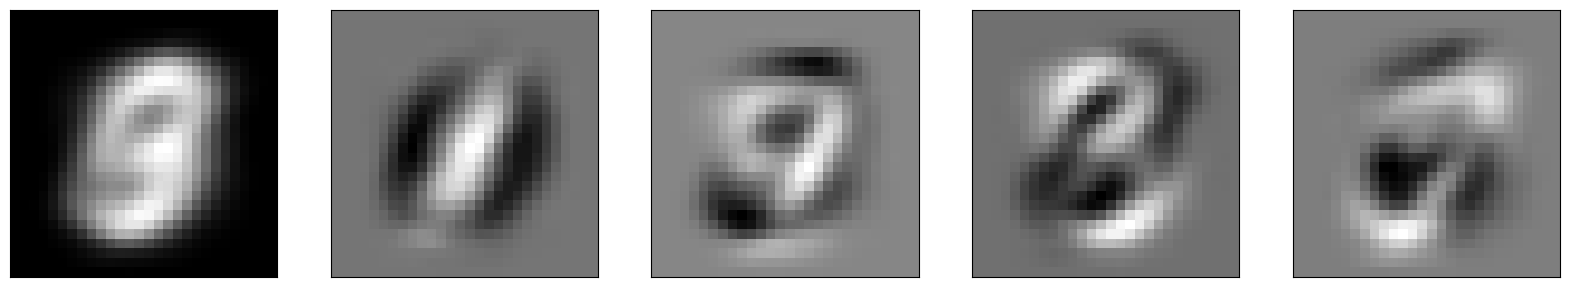

In [9]:
# 画像として見られるように配列の形を変更
ims = np.reshape(eigvec, (-1, 28, 28))

# 最初の5枚を確認してみる
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axs[i].imshow(ims[i], cmap="gray", interpolation=None)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

このように得られる固有ベクトルを画像としてみてみると、0から9の数字の影のようなものが見える。定性的には、これらの画像は数字の画像の共通成分のようなものを表わしており、これらの画像の線形結合を取ると、0-9に近しい画像が作れる、というわけである。

以下に、上記の5枚の画像をブレンドすることで、対話的に画像を変更できるシステムを用意してあるので、各自、スライダーを動かすことで画像がどのように変化するかを確認してみてほしい。

In [10]:
import numpy as np
from bokeh.models import Slider, CustomJS, ColumnDataSource
from bokeh.layouts import row, column
from bokeh.plotting import show, figure, output_notebook

output_notebook()

ws = np.random.uniform(-1.0, 1.0, size=(len(ims)))
im_avg = sum([w * im for w, im in zip(ws, ims)])

plot = figure(
    width=300,
    height=300,
    match_aspect=True,
    tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")],
)

w1 = Slider(start=-1.0, end=1.0, value=ws[0], step=0.05, title="w1")
w2 = Slider(start=-1.0, end=1.0, value=ws[1], step=0.05, title="w2")
w3 = Slider(start=-1.0, end=1.0, value=ws[2], step=0.05, title="w3")
w4 = Slider(start=-1.0, end=1.0, value=ws[3], step=0.05, title="w4")
w5 = Slider(start=-1.0, end=1.0, value=ws[4], step=0.05, title="w5")

source = ColumnDataSource(
    data={
        "im_avg": [im_avg],
        "im1": [ims[0]],
        "im2": [ims[1]],
        "im3": [ims[2]],
        "im4": [ims[3]],
        "im5": [ims[4]],
    }
)
plot.image(
    image="im_avg",
    source=source,
    x=0,
    y=0,
    dw=im_avg.shape[0],
    dh=im_avg.shape[1],
    palette="Greys256",
)

callback = CustomJS(
    args={"source": source, "w1": w1, "w2": w2, "w3": w3, "w4": w4, "w5": w5},
    code="""
   // Get image data
   const im_avg = source.data['im_avg'][0];
   const im1 = source.data.im1[0];
   const im2 = source.data.im2[0];
   const im3 = source.data.im3[0];
   const im4 = source.data.im4[0];
   const im5 = source.data.im5[0];

   // Get weights
   const w1_ = w1.value;
   const w2_ = w2.value;
   const w3_ = w3.value;
   const w4_ = w4.value;
   const w5_ = w5.value;

   // Image blending
   for (let i = 0; i < im_avg.length; i++) {
        im_avg[i] = w1_ * im1[i] + w2_ * im2[i] + w3_ * im3[i] + w4_ * im4[i] + w5_ * im5[i];
   }
   source.change.emit();
""",
)

w1.js_on_change("value", callback)
w2.js_on_change("value", callback)
w3.js_on_change("value", callback)
w4.js_on_change("value", callback)
w5.js_on_change("value", callback)

show(row(plot, column(w1, w2, w3, w4, w5)))

Loading BokehJS ...

図を見てみると、概ね同じ数字が近くに集まってクラスタを形成していることが分かる。上図は2次元までベクトルを圧縮して作成しているため、数字同士の領域に大きな重複が見られるが、もう少し高い次元であれば、各数字の占める領域が重ならないようにすることができそうだ。

なお、PCAをscikit-learnを用いて実行する場合には、以下のようになる。同様に2次元空間で可視化してみると、先ほどと同じ画像が得られていることが確認できる。

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_sr)
z_sr = pca.transform(X_sr)

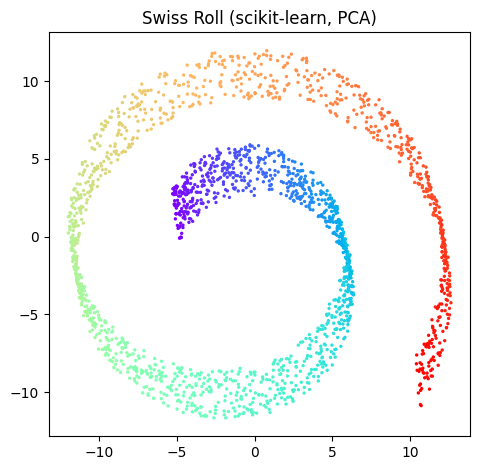

In [12]:
# データの可視化
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=2)
ax.set_title("Swiss Roll (scikit-learn, PCA)")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

## 多次元尺度構成法 (MDS)

**多次元尺度構成法**(MDS = Multi-Dimensional Scaling)は距離空間学習法の一種で元の空間における点と点の距離をなるべく保つように低次元空間に点を射影する。今回はデータとデータの間の距離を通常のEuclidノルムで求めて多次元尺度構成法を実行してみる。

多次元尺度構成法では、点と点の間の距離を表わす以下の行列$\mathbf{D} \in \mathbb{R}^{N \times N}$を考える。

$$
D_{ij} = \| \mathbf{x}_i - \mathbf{x}_j \|
$$

低次元空間における$\mathbf{x}_i$のベクトル表現$\mathbf{z}_i$は、この距離をできる限り保つように計算される。すなわち、任意の$\mathbf{z}_i$と$\mathbf{z}_j$の組に対して、

$$
\| \mathbf{z}_i - \mathbf{z}_j \| = D_{ij}
$$ (eq:z-vs-d)

となることが求められる。今、多次元尺度構成法では**距離だけを保てば良い**ので、$\mathbf{x}_1, \ldots, \mathbf{x}_N$の重心が原点となるように平行移動してある、すなわち、

$$
\sum_{i=1}^N \mathbf{x}_i = \mathbf{0}
$$ (eq:center-is-origin)

が成り立つとして、以下の議論を行う。始めに、{eq}`eq:z-vs-d`の両辺を二乗すると、

$$
D_{ij}^2 = \| \mathbf{z}_i \|^2 + \| \mathbf{z}_j \|^2 -2 \mathbf{z}_i^\top \mathbf{z}_j
$$ (eq:D-square)

となる。ここでさらに、

$$
\begin{align}
D_{i*} &= \sum_{j=1}^N D_{ij} \\
D_{*j} &= \sum_{i=1}^N D_{ij} \\
D_{**} &= \sum_{i,j} D_{ij} \\
\end{align}
$$

のように置くと、これらは、{eq}`eq:D-square`ならび{eq}`eq:center-is-origin`から、以下のように計算できる。

$$
\begin{align}
D_{i*} &= N \| \mathbf{z}_i \|^2 + \sum_{j=1} \| \mathbf{z}_j \|^2 \\
D_{*j} &= \sum_{i=1}^N \| \mathbf{z}_i \|^2 + N \| \mathbf{z}_j \|^2 \\
D_{**} &= 2N \sum_{i=1} \| \mathbf{z}_i \|^2
\end{align}
$$

これらの関係式を用いて、$\| \mathbf{z}_i \|^2$, $\| \mathbf{z}_j \|^2$, ならびに$\mathbf{z}_i^\top \mathbf{z}_j$を$D_{i*}$, $D_{*j}$, ならびに$D_{**}$を用いて書き直す。結果だけを示すと以下のようになる。

$$
\begin{align}
\| \mathbf{z}_i \|^2 &= \frac{1}{N} D_{*j}^2 - \frac{1}{2N^2} D_{**} \\
\| \mathbf{z}_j \|^2 &= \frac{1}{N} D_{i*}^2 - \frac{1}{2N^2} D_{**} \\
\mathbf{z}_i^\top \mathbf{z}_j &= \frac{1}{2} \left( \frac{1}{N} D_{i*}^2 + \frac{1}{N} D_{*j}^2 - \frac{1}{N^2} D_{**}^2 - D_{ij}^2 \right)
\end{align}
$$

かなり天下り的な説明になるが、これらの式を用いると、$\mathbf{Z} = [ \mathbf{z}_1 \cdots \mathbf{z}_N ] \in \mathbb{R}^{M \times N}$に対して、

$$
\mathbf{Z}^\top \mathbf{Z} = -\frac{1}{2} \mathbf{H} \mathbf{D}^2 \mathbf{H}
$$ (eq:mds)


という式が成り立つ。なお、ここでは、$\mathbf{D}^2$は$\mathbf{D}$の各要素を二乗したものであるとし、$\mathbf{H}$は以下のように定義される。

$$
\mathbf{H} = \mathbf{I} - \frac{1}{N} \mathbf{1} \mathbf{1}^\top
$$

ただし、$\mathbf{I}$は単位行列、$\mathbf{1}\mathbf{1}^\top$は全ての要素が1の$N\times N$要素を持つ行列であるとする。

今、{eq}`eq:mds`の右辺を$\mathbf{K}$と置くこととすると、$\mathbf{K}$は半正定値行列であり、$\mathbf{Z}$の解として、以下が得られる。

$$
\mathbf{Z} = [ \sqrt{\lambda_1} \mathbf{u}_1 \cdots \sqrt{\lambda_M} \mathbf{u}_M ]^\top
$$

ただし、$\{ \lambda_i \in \mathbb{R} : i = 1, \ldots, N \}$は、$\mathbf{K}$の固有値を絶対値が大きい順に並べたものであり、$\{ \mathbf{u}_i \in \mathbb{R}^{N} : i = 1, \ldots, N \}$は、それに対応する固有ベクトルである。

---

では、以上の議論を元にスイスロールのデータに対して多次元尺度構成法を適用してみる。なお、今回は、固有値分解を行う対象の行列が巨大であるため、SciPyの`eigh`関数を用いて、絶対値が大きい順に先頭から2個だけ固有値と固有ベクトルを求める。

In [13]:
import scipy as sp

# 距離行列の計算
n = len(X_sr)
X_sr_2 = np.sum(X_sr**2.0, axis=1, keepdims=True)
D_sr = X_sr_2 + X_sr_2.T -2.0 * X_sr @ X_sr.T

# MDS
H = np.eye(n) - np.ones((n, n)) / n
K_sr = -0.5 * (H @ (D_sr**2) @ H)

eigval, eigvec = sp.linalg.eigh(K_sr, subset_by_index=(n-2, n-1))
z_sr = eigvec * np.sqrt(np.maximum(0.0, eigval[None, :]))

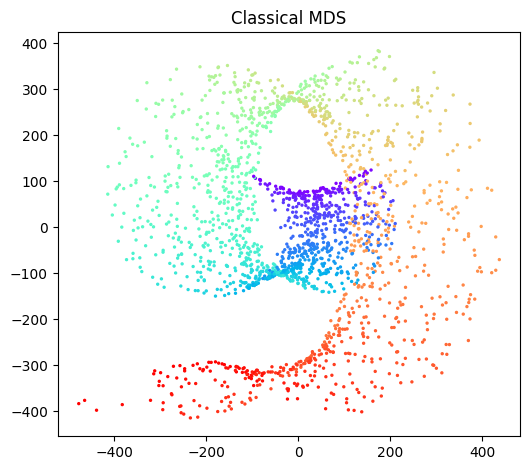

In [14]:
# データの可視化
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=2)
ax.set_title("Classical MDS")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

上記は最も古典的なMDSの実装であり、データのばらつきを見ると、PCAとそれほど遜色はない。一方、MDSにはデータの間の距離を調整するSMACOF(Scaling by MAjorizing a COmplicated Function)という手法が知られており、これを用いると、低次元空間におけるデータの配置を見やすくすることができる。

In [15]:
from tqdm.notebook import tqdm

# SMACOF
eps = 1.0e-6
max_iter = 20
k = 2
rng = np.random.RandomState(0)
z_sr = rng.uniform(size=(n, k))

old_stress = None

# SMACOF iterations
for _ in tqdm(range(max_iter)):
    dis = np.sqrt(np.sum((z_sr[:, None] - z_sr[None, :]) ** 2, axis=2))
    disparities = D_sr

    # Compute stress
    stress = ((dis.ravel() - disparities.ravel()) ** 2).sum() / 2
    # if normalized_stress:
    #     stress = np.sqrt(stress / ((disparities.ravel() ** 2).sum() / 2))

    # Update X using the Guttman transform
    dis[dis == 0] = 1e-5
    ratio = disparities / dis
    B = -ratio
    B[np.arange(len(B)), np.arange(len(B))] += ratio.sum(axis=1)
    z_sr = 1.0 / n * np.dot(B, z_sr)

    dis = np.sqrt((z_sr**2).sum(axis=1)).sum()
    if old_stress is not None:
        if (old_stress - stress / dis) < eps:
            break

    old_stress = stress / dis

  0%|          | 0/20 [00:00<?, ?it/s]

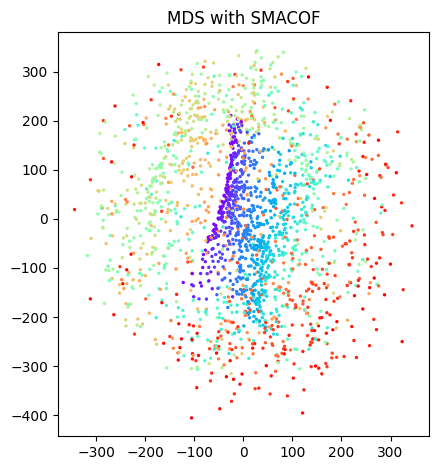

In [16]:
# データの可視化
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=2)
ax.set_title("MDS with SMACOF")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

上記と同様のコードがscikit-learnのMDSでも実装されており、結果を揃えるためには、以下のように引数を与えれば良い。

In [17]:
from sklearn.manifold import MDS

# 距離行列が求まっている場合には「dissimilarity="precomputed"」を指定する
mds = MDS(
    n_components=2,
    dissimilarity="precomputed",
    n_init=1,
    max_iter=20,
    random_state=np.random.RandomState(0),
    normalized_stress=False,
)
z_sr = mds.fit_transform(D_sr)

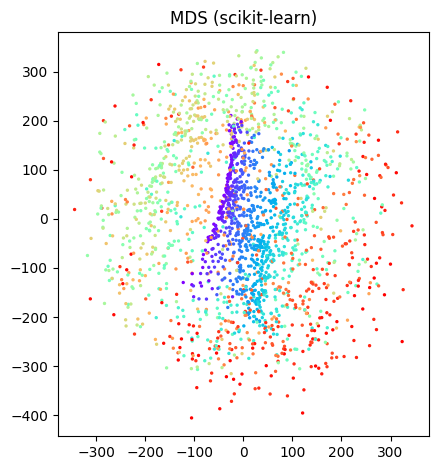

In [18]:
# データの可視化
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=2)
ax.set_title("MDS (scikit-learn)")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

### Isomapによる次元圧縮

実はIsomapはMDSを拡張した物で、距離行列にk-nearest neighbor graph (kNNグラフ)と呼ばれる、各点とその近傍を結んだグラフ構造上で計算された距離を用いる。このようなグラフを作成するために、下記のコードでは [KD木](https://en.wikipedia.org/wiki/K-d_tree)を用いた最近某探索を用いる。

In [19]:
from sklearn.neighbors import NearestNeighbors

# 各データ点に対する最近傍点の探索
n_neighbors = 5
kd_tree = NearestNeighbors(n_neighbors=n_neighbors + 1, algorithm="kd_tree")
kd_tree.fit(X_sr)
distances, indices = kd_tree.kneighbors(X_sr)

# 自分自身までの距離を除去
distances = distances[:, 1:]
indices = indices[:, 1:]

ここで`distances`と`indices`は`[1000, 5]`の大きさのデータになっていて、各頂点に対する近傍点までの距離と、近傍点のインデックスが入っている。なお、探索元のデータ群と探索先のデータ群を同じにすると、`distances[:, 0]`が自分自身の点までの距離で0となってしまうため、kNNグラフを作る際には、このようなデータを除去しておく。

次にグラフ計算のためのライブラリである`networkx`を用いて、グラフ上での点と点の距離を計算する。まずはグラフの作成。`networkx`でグラフを作成するためには`(i, j, {"weight": 1.0})`のような辺の端点を表わす点のインデックス`i`, `j`と、辺に対する重みの除法を表わす`{"weight": 1.0}`を辺の数分だけ配列に格納し、その配列を用いて `from_edgelist` からグラフを作成する。

In [20]:
# kNNグラフの作成
import networkx as nx

# 辺のデータの収集
edges = []
for i in range(n):
    for j in range(n_neighbors):
        edges.append((i, indices[i, j], {"weight": distances[i, j]}))
        edges.append((indices[i, j], i, {"weight": distances[i, j]}))

# グラフの作成
G = nx.from_edgelist(edges)

グラフが作成できたら、[Warshall-Floyd法](https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm)によって、全点対間の距離を計算する。なお、Warshall-Floyd法はグラフの頂点数 $n$に対して $O(n^3)$のアルゴリズムなので、計算量に注意すること。

In [21]:
# Warshall-Floyd法による全点対間距離の計算
# 注意: networkxのグラフのノードはインデックス順になっていないので、第2引数にノード順を指定する
D = nx.floyd_warshall_numpy(G, nodelist=np.arange(n))

ここまででkNNグラフ上での頂点間距離が

In [22]:
n = len(X_sr)
H = np.eye(n) - np.ones((n, n)) / n
K = -0.5 * (H @ (D**2) @ H)
eigval, eigvec = sp.linalg.eigh(K, subset_by_index=(n-2, n-1))

eigval = np.flip(eigval)
eigvec = np.flip(eigvec, axis=1)

# 注意: scikit-learnと結果を揃えるために-1を掛ける (固有値, 固有ベクトルの符号には曖昧さがある)
z_sr = eigvec * np.sqrt(eigval[None, :])

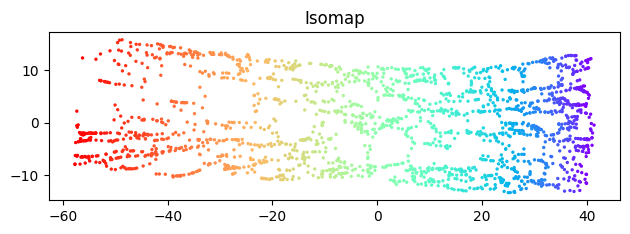

In [23]:
# データの可視化
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=2)
ax.set_title("Isomap")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

In [24]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2, n_neighbors=5, neighbors_algorithm="kd_tree", path_method="FW")
z_sr = isomap.fit_transform(X_sr)

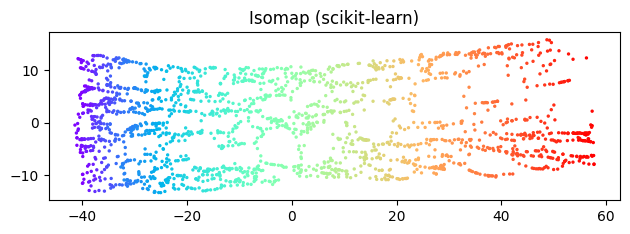

In [25]:
# データの可視化
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=2)
ax.set_title("Isomap (scikit-learn)")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

### LLEによる次元圧縮

In [26]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
z_sr = lle.fit_transform(X_sr)

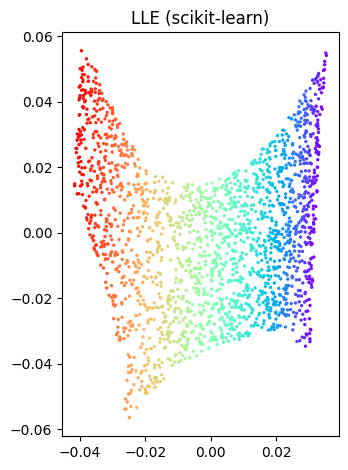

In [27]:
# データの可視化
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=2)
ax.set_title("LLE (scikit-learn)")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

## 練習問題

- 多次元尺度構成法の項で紹介した{eq}`eq:mds`を自身で導出せよ。
- 単純なMDSとSMACOFを用いたMDSをMNISTのデータに適用し、違いについて考察せよ。 